# Assignment 1: Image classification

In [30]:
# Load packages
import numpy as np
import cv2
import os
import random

from keras.preprocessing.image import img_to_array, array_to_img
from keras.models import Sequential, load_model
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.datasets import cifar10
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from matplotlib.pyplot import imshow

%matplotlib inline

## 1. Load "Face_humain" dataset

In [2]:
# Define the data directory
path_data = 'E:/Downloads/lfw-funneled/lfw_funneled'

In [3]:
# Get the filenames from directory
link_names = []
for (rootDir, dirNames, filenames) in os.walk(path_data):
    for filename in filenames:
        if filename.endswith('.jpg'):
            link_names.append(os.path.join(rootDir, filename))

In [6]:
# Check length
print("There are {} images in the directory".format(len(link_names)))

There are 13233 images in the directory


In [7]:
# Shuffle with a fixed seed so that the split is reproducible
random.seed(167)
random.shuffle(link_names)

In [8]:
# Randomly pick 7000 images
filePaths = link_names[:7000]

In [9]:
# Preprocess data: resize and load to array
def load_and_resize(filePaths):
    data = []
    for filename in filePaths:
        image = cv2.imread(filename)
        image = cv2.resize(image, (32, 32))
        image = img_to_array(image)
        data.append(image)
    return np.array(data)  

In [10]:
# Get dataset
faces = load_and_resize(filePaths)
print("Shape = " + str(faces.shape))

Shape = (7000, 32, 32, 3)


## 2. Load Cifar10 dataset from keras.datasets

In [11]:
# Load the training and testing CIRFA10 dataset
((train_x, train_y), (test_x, test_y)) = cifar10.load_data()

In [12]:
# Normalize image vectors
faces = faces/255.
train_x = train_x/255.
test_x = test_x/255.

In [13]:
# Split Faces_humain dataset
(train_faces, test_faces) = train_test_split(faces, test_size = 2000, random_state = 1)

In [14]:
# Create labels for faces_humain dataset
train_faces_label = 10*np.ones((5000, 1)).astype('int')
test_faces_label = 10*np.ones((2000, 1)).astype('int')

## 3. Concatenate two datasets

In [15]:
X_train = np.concatenate((train_x, train_faces), axis = 0)
X_test = np.concatenate((test_x, test_faces), axis = 0)
Y_train = np.r_[train_y, train_faces_label]
Y_test = np.r_[test_y, test_faces_label]

In [16]:
# Convert the labels from integers to vectors
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)

In [79]:
# Initialize the label names the dataset
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck", "face_humain"]

## 4. Build and Train MiniVGG Network

In [18]:
def MiniVGGNet(width, height, depth, classes):
    model = Sequential()
    input_shape = (height, width, depth)
    
    # First CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    # Second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    # First set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(units = 512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Softmax classifier
    model.add(Dense(units = classes))
    model.add(Activation('softmax'))
    
    return model

In [105]:
# optimizer = SGD(lr = 0.01, momentum = 0.9)
# model = MiniVGGNet(32, 32, 3, 11)
# model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
# H = model.fit(X_train, Y_train, batch_size = 64, validation_data = (X_test, Y_test), verbose = 1, epochs = 40)

In [21]:
# Load pretrained model
model = load_model('C:/Users/Admin/THANG HOANG/Course Practical Deep Learning/40epochs.h5')

In [22]:
# Evaluate on the test sets
model.evaluate(x = X_test, y = Y_test, batch_size = 64)

12000/12000 [==============================] - 240s 20ms/step


[0.5370336002111435, 0.8456666666666667]

## 5. Conclusion

My model (Mini VGG Network) gets around 85% test accuracy and 90% train accuracy in 40 epochs (trained by Google Colab) with a mini batch size of 64 and "SGD" optimizer. I think if we use data augmention and adjust dropout, take more time to train, we should get more accuracy.

In [28]:
#  Randomly pick indice of 10 images from test sets to perform
idx = np.random.randint(0, X_test.shape[0], 10)

In [76]:
# Predict class of these 10 images
Y_test_pred = model.predict(X_test[idx])
preds = Y_test_pred.argmax(axis = 1)
preds

array([ 7,  3,  7, 10,  2,  3,  7,  8,  7, 10], dtype=int64)

In [77]:
# Get true class of these 10 images
true = Y_test[idx].argmax(axis = 1)
true

array([ 7,  3,  7, 10, 10,  3,  4,  8,  7, 10], dtype=int64)

True class: face_humain
Predicted class: bird


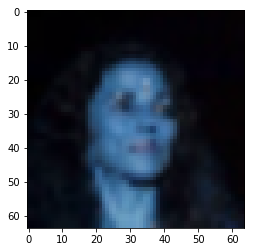

In [80]:
# Display an image which is wrongly classified 
image = cv2.resize(X_test[idx[4]], (64, 64))
imshow(image)
print("True class: {}".format(label_names[true[4]]))
print("Predicted class: {}".format(label_names[preds[4]]))

True class: deer
Predicted class: horse


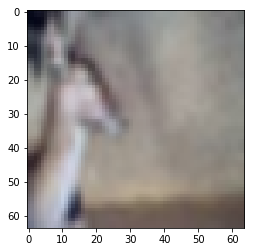

In [82]:
# Display an other image which is wrongly classified 
image = cv2.resize(X_test[idx[6]], (64, 64))
imshow(image)
print("True class: {}".format(label_names[true[6]]))
print("Predicted class: {}".format(label_names[preds[6]]))